<a href="https://colab.research.google.com/github/Gr0o00t/Reservoir/blob/main/Decline_Curve_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
def hyperbolic(t, qi, di, b):
  """
  Hyperbolic decline function
  """
  import numpy as np
  return qi / (np.abs((1 + b * di * t))**(1/b))

def arps_fit(t, q, plot=None):

  import numpy as np
  import datetime
  from scipy.optimize import curve_fit
  import matplotlib.pyplot as plt

 
  
  def rmse(y, yfit):
    N = len(y)
    return np.sqrt(np.sum(y-yfit)**2 / N)

  # subtract one datetime to another datetime
  date = t
  timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
  timedelta = np.array(timedelta)
  timedelta = timedelta / datetime.timedelta(days=1)


  # take cumulative sum over timedeltas
  t = np.cumsum(timedelta)
  t = np.append(0, t)
  t = t.astype(float)
  
  # normalize the time and rate data
  t_normalized = t / max(t)
  q_normalized = q / max(q)  

  # fitting the data with the hyperbolic function
  popt, pcov = curve_fit(hyperbolic, t_normalized, q_normalized)
  qi, di, b = popt

  # RMSE is calculated on the normalized variables
  qfit_normalized = hyperbolic(t_normalized, qi, di, b)
  RMSE = rmse(q_normalized, qfit_normalized)

  # De-normalize qi and di
  qi = qi * max(q)
  di = di / max(t)

  if plot==True:
    # Print all parameters and RMSE
    print('Initial production rate (qi)  : {:.5f} VOL/D'.format(qi))
    print('Initial decline rate (di)     : {:.5f} VOL/D'.format(di))
    print('Decline coefficient (b)       : {:.5f}'.format(b))
    print('RMSE of regression            : {:.5f}'.format(RMSE))  

    # Produce the hyperbolic curve (fitted)
    tfit = np.linspace(min(t), max(t), 100)
    qfit = hyperbolic(tfit, qi, di, b)

    # Plot data and hyperbolic curve
    plt.figure(figsize=(10,7))

    plt.step(t, q, color='blue', label="Data")
    plt.plot(tfit, qfit, color='red', label="Hyperbolic Curve")
    plt.title('Decline Curve Analysis', size=20, pad=15)
    plt.xlabel('Days')
    plt.ylabel('Rate (SCF/d)')
    plt.xlim(min(t), max(t)); plt.ylim(ymin=0)

    plt.legend()
    plt.grid()
    plt.show()

  return qi, di, b, RMSE



def remove_outlier(df, column_name, window, number_of_stdevs_away_from_mean, trim=False):

  import pandas as pd

  df[column_name+'_rol_Av']=df[column_name].rolling(window=window, center=True).mean()
  df[column_name+'_rol_Std']=df[column_name].rolling(window=window, center=True).std()

  # Detect anomalies by determining how far away from the mean (in terms of standard deviation)
  df[column_name+'_is_Outlier']=(abs(df[column_name]-df[
                              column_name+'_rol_Av'])>(
                              number_of_stdevs_away_from_mean*df[
                              column_name+'_rol_Std']))
  
  # outlier and not-outlier will be recorded in the '_is_Outlier'
  # column as 'True' and 'False'. Now, outlier is removed, so column that
  # contains 'True' values are masked out
  result = df.drop(df[df[column_name+'_is_Outlier'] == True].index).reset_index(drop=True)

  # Remove rows where "_rol_Av" has NaNs
  result = result[result[column_name+'_rol_Av'].notna()]  

  if trim==True:
    # Trim initial buildup
    maxi = result[column_name+'_rol_Av'].max()
    maxi_index = (result[result[column_name+'_rol_Av']==maxi].index.values)[0]
    result = result.iloc[maxi_index:,:].reset_index(drop=True)

  return result  

def convert_date_to_days(t):
  """
  Convert Numpy Datetime to Days 
  """
  import datetime
  import numpy as np
  
  # subtract one datetime to another datetime
  timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
  timedelta = np.array(timedelta)
  timedelta = timedelta / datetime.timedelta(days=1)

  # take cumulative sum over timedeltas
  t = np.cumsum(timedelta)
  t = np.append(0, t)
  t = t.astype(float)
  return t

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#from dca import arps_fit,remove_outlier

#PRODUCTION DATA

path = "https://bit.ly/piopetro-data1"

df = pd.read_csv(path)
df

,DATEPRD,NPD_WELL_BORE_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND
0,07-Apr-14,15/9-F-1 C,0.0,0.000,0.000,0.000,0.000,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
1,08-Apr-14,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,1.00306,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
2,09-Apr-14,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,0.97901,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
3,10-Apr-14,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,0.54576,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
4,11-Apr-14,15/9-F-1 C,0.0,310.376,96.876,277.278,0.000,1.21599,33.098,10.480,33.072,0.0,0.0,0.0,NaN,production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,14-Sep-16,15/9-F-5,0.0,NaN,NaN,NaN,0.273,0.63609,0.078,0.229,0.019,0.0,0.0,0.0,NaN,production
15630,15-Sep-16,15/9-F-5,0.0,NaN,NaN,NaN,0.287,0.67079,0.085,0.229,0.006,0.0,0.0,0.0,NaN,production
15631,16-Sep-16,15/9-F-5,0.0,NaN,NaN,NaN,0.286,0.66439,0.085,0.229,0.012,0.0,0.0,0.0,NaN,production
15632,17-Sep-16,15/9-F-5,0.0,NaN,NaN,NaN,0.272,0.62466,0.075,0.228,0.026,0.0,0.0,0.0,NaN,production


In [21]:
#CONVERT DATE COLUMN TO PANDAS DATELINE FORMAT

df["DATEPRD"] = pd.to_datetime(df["DATEPRD"], format = "%d-%b-%y")
df

,DATEPRD,NPD_WELL_BORE_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND
0,2014-04-07,15/9-F-1 C,0.0,0.000,0.000,0.000,0.000,0.00000,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
1,2014-04-08,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,1.00306,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
2,2014-04-09,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,0.97901,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
3,2014-04-10,15/9-F-1 C,0.0,NaN,NaN,NaN,0.000,0.54576,0.000,0.000,0.000,0.0,0.0,0.0,NaN,production
4,2014-04-11,15/9-F-1 C,0.0,310.376,96.876,277.278,0.000,1.21599,33.098,10.480,33.072,0.0,0.0,0.0,NaN,production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2016-09-14,15/9-F-5,0.0,NaN,NaN,NaN,0.273,0.63609,0.078,0.229,0.019,0.0,0.0,0.0,NaN,production
15630,2016-09-15,15/9-F-5,0.0,NaN,NaN,NaN,0.287,0.67079,0.085,0.229,0.006,0.0,0.0,0.0,NaN,production
15631,2016-09-16,15/9-F-5,0.0,NaN,NaN,NaN,0.286,0.66439,0.085,0.229,0.012,0.0,0.0,0.0,NaN,production
15632,2016-09-17,15/9-F-5,0.0,NaN,NaN,NaN,0.272,0.62466,0.075,0.228,0.026,0.0,0.0,0.0,NaN,production


In [22]:
mask = df["NPD_WELL_BORE_NAME"] == "15/9-F-14"
df2 = df[mask].reset_index()

df2 = df2[["DATEPRD" , "BORE_OIL_VOL"]]
df2

,DATEPRD,BORE_OIL_VOL
0,2008-02-12,0.0
1,2008-02-13,0.0
2,2008-02-14,0.0
3,2008-02-15,0.0
4,2008-02-16,0.0
...,...,...
3051,2016-09-13,0.0
3052,2016-09-14,0.0
3053,2016-09-15,0.0
3054,2016-09-16,0.0


Text(0.5, 0, 'years')

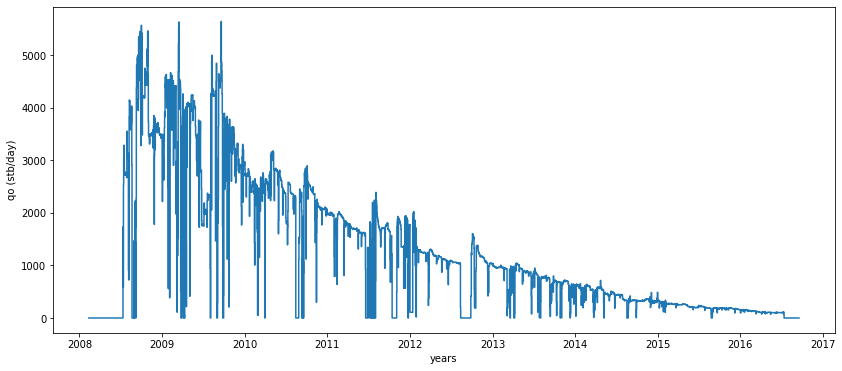

In [23]:
plt.figure(figsize = (14,6))
plt.step(df2["DATEPRD"] , df2["BORE_OIL_VOL"])
plt.ylabel("qo (stb/day)") ; plt.xlabel("years")


In [24]:
df_new=remove_outlier(df2,"BORE_OIL_VOL",10,10, trim= True)
df_new

,DATEPRD,BORE_OIL_VOL,BORE_OIL_VOL_rol_Av,BORE_OIL_VOL_rol_Std,BORE_OIL_VOL_is_Outlier
0,2008-09-30,3282.0,5021.2,656.561718,False
1,2008-10-01,5320.0,5075.2,665.799736,False
2,2008-10-02,5570.0,4878.3,815.622060,False
3,2008-10-03,5282.0,4810.4,841.289117,False
4,2008-10-04,4954.0,4715.6,851.246563,False
...,...,...,...,...,...
2818,2016-09-09,0.0,0.0,0.000188,False
2819,2016-09-10,0.0,0.0,0.000188,False
2820,2016-09-11,0.0,0.0,0.000188,False
2821,2016-09-12,0.0,0.0,0.000188,False


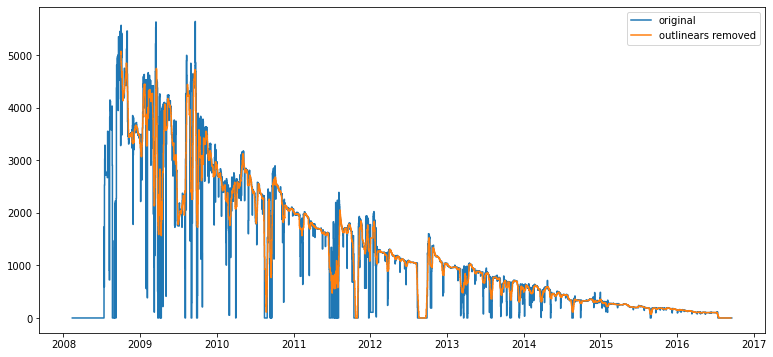

In [25]:
plt.figure(figsize=(13,6))
plt.step(df2['DATEPRD'],df2["BORE_OIL_VOL"], label="original")
plt.step(df_new["DATEPRD"],df_new["BORE_OIL_VOL_rol_Av"] ,label="outlinears removed")
plt.legend()
plt.show()

In [26]:
t=df_new["DATEPRD"]
q=df_new["BORE_OIL_VOL_rol_Av"]

Initial production rate (qi)  : 4020.33197 VOL/D
Initial decline rate (di)     : 0.00083 VOL/D
Decline coefficient (b)       : -0.24922
RMSE of regression            : 0.01734


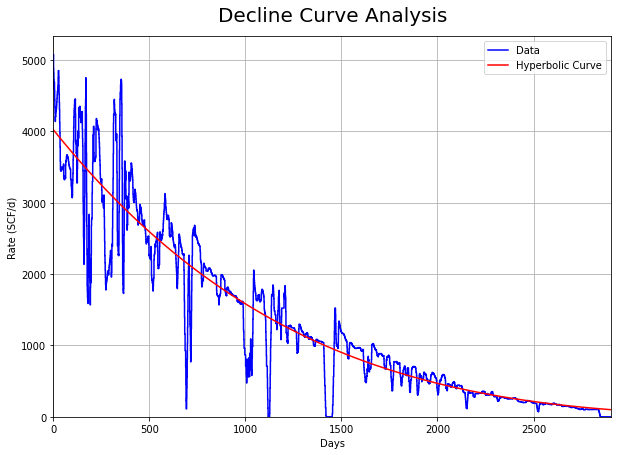

(4020.3319721583994,
 0.0008321119857877351,
 -0.24921511106068375,
 0.017344524416507086)

In [27]:
arps_fit(t,q,plot=True)